## Tool Loadout using LangGraph

In [2]:
! pip install langgraph_bigtool

In [12]:
## Importing Necessary Modules
import math  
import types
import uuid

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings

from langgraph.store.memory import InMemoryStore

from langgraph_bigtool.utils import convert_positional_only_function_to_tool

In [27]:
## Select LLM 
llm_model = input()

## Initialize the language model for the agent
if llm_model == "qwen":
    llm = init_chat_model("ollama:qwen2.5:7b-instruct", temperature=0)
elif llm_model == "mistral":
    llm = init_chat_model("ollama:mistral:7b", temperature=0)

## Define the tools
## Extract and convert all mathematical functions from Python's math module
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    
    ## Only process built-in mathematical functions
    if not isinstance(function, types.BuiltinFunctionType):
        continue
        
    ## Convert math functions to LangChain tools (handles positional-only parameters)
    if tool := convert_positional_only_function_to_tool(function):
        all_tools.append(tool)

## Create a tool registry mapping unique IDs to tool instances
## This allows for efficient tool lookup and management
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

## Set up vector store for semantic tool search
## Uses embeddings to enable similarity-based tool selection
embeddings = init_embeddings("ollama:nomic-embed-text")

## InMemory Store stores the data in memory and can be accessible throughout different threads
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  ## embedding dimensions
        "fields": ["description"],  ## Index tool descriptions for search
    }
)

## Index all tools in the store for semantic similarity search
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),  ## Namespace for tool storage
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

In [28]:
## Import standard and third-party packages
from typing import Dict, Any
from typing_extensions import Literal

## LangChain core components
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

## LangGraph components for workflow and state management
from langgraph.store.base import BaseStore
from langgraph.graph import END, START, StateGraph, MessagesState

## Jupyter display utilities
from IPython.display import Image, display

## Extended state class to store dynamically selected tools
class ToolLoadoutState(MessagesState):
    """State that extends MessagesState to include dynamically selected tools.
    
    This allows the agent to maintain context about which tools are currently
    available and bound to the conversation.
    """
    tools_by_name: Dict[str, Any] = {}


## Define the Nodes
## System prompt defining the agent's role and capabilities
system_prompt = """You are a helpful assistant with access to mathematical functions from Python's math library. 
You can search for and use relevant mathematical tools to solve problems. 
When you need to perform mathematical calculations, first determine what type of mathematical operation you need, 
then use the appropriate tools from the math library."""

def llm_call(state: ToolLoadoutState, store: BaseStore) -> dict:
    """Main LLM call that dynamically selects and binds relevant tools.
    
    This function implements the core tool loadout pattern:
    1. Extract query context from user message
    2. Search for semantically relevant tools  
    3. Bind only relevant tools to the LLM
    4. Generate response with focused tool set
    
    Args:
        state: Current conversation state containing messages and tools
        store: Vector store containing indexed tool descriptions
        
    Returns:
        Dictionary with new messages and updated tool registry
    """
    # Extract user query for semantic tool search
    messages = state["messages"]
    if messages and isinstance(messages[-1], HumanMessage):
        query = messages[-1].content
    else:
        query = "mathematical calculation"  ## Default fallback
    
    ## Perform semantic similarity search to find relevant tools
    search_results = store.search(("tools",), query=query, limit=5)
    
    ## Build focused tool set from search results
    relevant_tools = []
    tools_by_name = {}
    
    for result in search_results:
        tool_id = result.key
        if tool_id in tool_registry:
            tool = tool_registry[tool_id]
            relevant_tools.append(tool)
            tools_by_name[tool.name] = tool
    
    ## Bind only relevant tools to avoid context overload
    llm_with_tools = llm.bind_tools(relevant_tools) if relevant_tools else llm
    
    ## Generate response with focused context
    response = llm_with_tools.invoke(
        [SystemMessage(content=system_prompt)] + state["messages"]
    )
    
    return {
        "messages": [response],
        "tools_by_name": tools_by_name
    }

def tool_node(state: ToolLoadoutState) -> dict:
    """Execute tool calls using the dynamically selected tool set.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool execution results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        ## Retrieve tool from the focused set stored in state
        tool = state["tools_by_name"][tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: ToolLoadoutState) -> Literal["tool_node", "__end__"]:
    """Determine workflow continuation based on tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node name or END
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    ## Continue to tool execution if LLM made tool calls
    if last_message.tool_calls:
        return "tool_node"
    
    ## Otherwise end the conversation
    return END

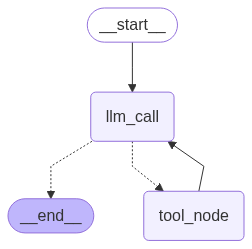

In [29]:
## Build the tool loadout workflow
agent_builder = StateGraph(ToolLoadoutState)

## Add the nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

## Define the Edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",
        END: END,
    },
)
agent_builder.add_edge("tool_node", "llm_call")

## Compile the agent with tool store for semantic search
agent = agent_builder.compile(store=store)

## Display the workflow 
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [30]:
## Defining Different Users based on Message Response
from typing import Iterable, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

def _role_of(msg: Any) -> str:
    """Infer a role string from LangChain message objects or dicts."""
    if isinstance(msg, HumanMessage):
        return "User"
    if isinstance(msg, AIMessage):
        return "Agent"
    if isinstance(msg, SystemMessage):
        return "System"
    if isinstance(msg, ToolMessage):
        return "AI Tool"
    if isinstance(msg, BaseMessage):
        # Fallback for other BaseMessage subclasses
        return getattr(msg, "type", msg.__class__.__name__.lower())
    if isinstance(msg, dict):
        return msg.get("role", "unknown")
    return msg.__class__.__name__.lower()

def _content_of(msg: Any) -> str:
    """Extract textual content from LangChain message objects or dicts."""
    if isinstance(msg, BaseMessage):
        c = msg.content
        return c if isinstance(c, str) else str(c)
    if isinstance(msg, dict):
        return str(msg.get("content", ""))
    return str(msg)

In [31]:
## Define the format messages
def format_messages(messages: Iterable[Any]) -> str:
    """
    Pretty-print a sequence of chat messages.
    Supports LangChain BaseMessage subclasses and dicts with {'role','content'}.
    Also prints AI tool calls if present.
    """
    lines = []
    for m in messages:
        role = _role_of(m).capitalize()
        content = _content_of(m)

        ## Handle AI tool calls (LangChain >= 0.2 exposes .tool_calls on AIMessage)
        tool_calls_txt = ""
        if isinstance(m, AIMessage):
            tool_calls = getattr(m, "tool_calls", None)
            if tool_calls:
                parts = []
                for tc in tool_calls:
                    name = tc.get("name") or tc.get("function", {}).get("name") or "tool"
                    args = tc.get("args") or tc.get("function", {}).get("arguments")
                    parts.append(f"- call {name}({args})")
                tool_calls_txt = ("\nTool calls:\n" + "\n".join(parts)) if parts else ""

        if isinstance(m, ToolMessage):
            tool_name = getattr(m, "name", "tool")
            lines.append(f"Tool ({tool_name}): {content}")
        else:
            lines.append(f"{role}: {content}{tool_calls_txt}")

    return "\n".join(lines)

In [ ]:
## Invoke the Agent
from langchain_core.messages import HumanMessage

query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})
if llm_model == "qwen":
    print(format_messages(result['messages']))
    print(result)

User: Use available tools to calculate arc cosine of 0.5.
Agent: 
Tool calls:
- call acos({'x': 0.5})
Tool (None): 1.0471975511965979
Agent: The arc cosine of 0.5 is approximately 1.047 radians, which is equivalent to 60 degrees.
{'messages': [HumanMessage(content='Use available tools to calculate arc cosine of 0.5.', additional_kwargs={}, response_metadata={}, id='9eff8df7-45a0-496e-a10b-f7571f1768b7'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b-instruct', 'created_at': '2025-09-04T03:56:28.8593635Z', 'done': True, 'done_reason': 'stop', 'total_duration': 25698302600, 'load_duration': 15040934900, 'prompt_eval_count': 493, 'prompt_eval_duration': 5750857500, 'eval_count': 21, 'eval_duration': 4867450300, 'model_name': 'qwen2.5:7b-instruct'}, id='run--c8e2112f-4fa8-4cd5-b8be-117c0ad7d461-0', tool_calls=[{'name': 'acos', 'args': {'x': 0.5}, 'id': 'f6f43074-4318-44af-b17f-b8be0cc7d843', 'type': 'tool_call'}], usage_metadata={'input_tokens': 493, '

In [32]:
## Similarly Checking the tool call invocation with a ollama chat model 
## Invoke the Agent
from langchain_core.messages import HumanMessage

query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})
if llm_model == "mistral":
    print(format_messages(result['messages']))
    print(result)

User: Use available tools to calculate arc cosine of 0.5.
Agent:  To find the arc cosine (acos) of 0.5, we can use the `acos` function from Python's math library:

```python
import math
result = math.acos(0.5)
print(result)
```

This code will output the result in radians. If you want to convert it to degrees, multiply the result by 180/math.pi.
{'messages': [HumanMessage(content='Use available tools to calculate arc cosine of 0.5.', additional_kwargs={}, response_metadata={}, id='fc8b86dc-b1d3-40c7-b564-bc2de1913595'), AIMessage(content=" To find the arc cosine (acos) of 0.5, we can use the `acos` function from Python's math library:\n\n```python\nimport math\nresult = math.acos(0.5)\nprint(result)\n```\n\nThis code will output the result in radians. If you want to convert it to degrees, multiply the result by 180/math.pi.", additional_kwargs={}, response_metadata={'model': 'mistral:7b', 'created_at': '2025-09-04T04:10:46.9772281Z', 'done': True, 'done_reason': 'stop', 'total_duration